Author: Yunnuo (Noah) Zhang

In [1]:
# -*- coding: utf-8 -*-

In [27]:
import string
import nltk
import numpy as np
from nltk.stem import PorterStemmer
from nltk.corpus import stopwords
import sklearn
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.feature_extraction.text import TfidfVectorizer
from nltk.metrics import windowdiff

import matplotlib.pyplot as plt

In [3]:
#Function to plot graphs required for Text Tiling Algorithm
def plot_fig(x,score,heading,fig_no):
    fig = plt.figure(fig_no,figsize=(10,6))
    ax = fig.add_subplot(111)
    ax.plot(x,score,label=heading)
    ax.legend()

In [4]:
#Open file in python

f = open('alien-life.txt','r')
doc=f.read()
f.close()
# The em-dash(long hyphen) is not recognised by ASCII. So, it is replaced with the hyphen.
if "—" in doc:
    doc = doc.replace("—", "-")
#The original encoding of the text-file is in utf-8 format.So decoding the string from utf-8
doc=doc.decode('utf-8')
#Encoding it into ascii format
doc=doc.encode('ascii','ignore')
doc=doc.lower()

FileNotFoundError: [Errno 2] No such file or directory: 'alien-life.txt'

In [5]:
from google.colab import files

uploaded = files.upload()

for fn in uploaded.keys():
  print('User uploaded file "{name}" with length {length} bytes'.format(
      name=fn, length=len(uploaded[fn])))

ModuleNotFoundError: No module named 'google.colab'

In [6]:
#Open file in python
f = open('transcript.txt','r')
doc=f.read()
f.close()
# The em-dash(long hyphen) is not recognised by ASCII. So, it is replaced with the hyphen.
if "—" in doc:
    doc = doc.replace("—", "-")
#The original encoding of the text-file is in utf-8 format.So decoding the string from utf-8
# doc=doc.decode('utf-8')
#Encoding it into ascii format
doc=doc.encode('ascii','ignore')
doc=doc.lower()

In [7]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Jason\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [12]:
#Saving a copy of original corpus along with the $$ sign to be later used for Windowdiff measure
doc_copy=doc
ref_word=[]
p = re.compile(r'(\n)|(\r)|(\t)|([!"#%&()*+,-./:;<=>?@\[\\\]^_`{|}~])', re.IGNORECASE)
doc_copy=doc_copy.decode('utf-8')
doc_copy=re.sub(p,' ',doc_copy)
stemmer=PorterStemmer()
for word in doc_copy.split(" "):
    if word not in stopwords.words('english') and stemmer.stem(word) not in stopwords.words('english'):
        if word!=" " and word!="":
            ref_word.append(stemmer.stem(word))

###TextTiling Algorithm

In [30]:
print(doc_copy)

#Preparation for TextTiling Algorithm Implementation
#Stripping punctuation
#Removing new-line characters and punctuations
p = re.compile(r'(\n)|(\r)|(\t)|([!"#$%&()*+,-./:;<=>?@\[\\\]^_`{|}~])', re.IGNORECASE)
doc=re.sub(p,' ',doc_copy)

 18 06 linear algebra  spring 2010 transcript  lecture 8 ok  when the camera says  we'll start  you want to give me a signal  ok  this is lecture eight in linear algebra  and this is the lecture where we completely solve linear equations  so ax b  that's our goal  if it has a solution  it certainly can happen that there is no solution  we have to identify that possibility by elimination  and then if there is a solution we want to find out is there only one solution or are    is there a whole family of solutions  and then find them all  ok  can i use as an example the same matrix that i had last time when we were looking for the null space  so the  the matrix has rows 1 2 2 2  2 4 6 8  and the third row    you remember the main point was the third row  3 6 8 10  is the sum of row one plus row two  in other words  if i add those left hand sides  i get the third left hand side  so you can tell me right away what elimination is going to discover about the right hand sides  what's    there 

In [24]:
#Sen_length represents the desired sentence length that we are focusing on 
#Doc represents the corpus of text
#Fig no represents the figure no that we want to give to the graph
def text_tiling(doc,sen_len,fig_no):
    
    #Porter Stemming and removing stop words
    stemmer=PorterStemmer() 
    sentences=[]
    sentence=""
    j=0
    for word in doc.split(" "):
        if word not in stopwords.words('english') and word!=" " and word!="":
            j=j+1
            sentence=sentence + stemmer.stem(word)+' '
            if j==sen_len:
                # -1 is to prevent the whitespace that is appended at the end to be included in the sentence
                sentences.append(sentence[:-1])
                sentence=""
                j=0
    #If the last sentence is of length less than sen_length
    sentences.append(sentence[:-1])
 
    #Vectorizing Sentences using Sklearn to determine Cosine Similarity between adjacent sentences
    tfidf_vectorizer = TfidfVectorizer()
    tfidf_matrix = tfidf_vectorizer.fit_transform(sentences)
    score=[]
    for i in range(0,tfidf_matrix.shape[0]-2):
        score.append(cosine_similarity(tfidf_matrix[i:i+1], tfidf_matrix[i+1:i+2])[0][0])
    
    #Plotting Cosine Similarity 
    plot_fig(range(1,tfidf_matrix.shape[0]-1),score,'Lexical Similarity with Sentence Length '+ str(sen_len),fig_no)
    
    #Implementing Windowdiff measure
    mean_score=np.mean(score)
    std_score=np.std(score)
    #Threshold is defined as Mean Score - Standard Deviation
    threshold=mean_score-std_score
    boundary=[]
    for i in range(0,len(score)-2): 
        #score[0] represents the cosine similarity between sentence 1 and sentence 2, score[1] between 2 and 3 and score[2] between 3 and 4
        #If depth is greater than threshold, then there will be a dissimilariy between sentence 2 and sentence 3, so we are marking sentence 2 as the boundary
        depth=score[i]-score[i+1]+score[i+2]-score[i+1]
        if depth>=threshold:
            boundary.append(i+1) #Storing positions of Sentences that represent a boundary
    #Replacing boundaries with 1 and words with 0
    boundary_string=''
    for i in range(0,len(sentences)):
        boundary_string=boundary_string+sentences[i]+' '
        if i in boundary:
            boundary_string=boundary_string+' $$ '  
        
    return boundary_string


###Windowdiff Measure

In [25]:
def window_diff(ref_word,doc,sen_len,fig_no):
    #Call to TextTiling Function
    hypo=text_tiling(doc,sen_len,fig_no)
    #Splitting Hypothesis Words
    hypo_words=[word for word in hypo.split(' ') if word!='' and word not in stopwords.words('english')]
    #Storing supervised input
    para_words=ref_word
    i=0
    j=0
    hypo_string=''
    para_string=''
    # What this loop does can be explained by an example: Suppose we have total of 3 words and 
    # we have boundaries after two words in hypothesis  (hey man $$ yep) and after one word in training( hey $$ man yep)
    # so this would represent hypothesis string as 00010(0(hey)0($$ in reference)0(man)1($$ in hypothesis)0(yep)) 
    # reference string as 01000 (0(hey)1($$ in ref)0(man)0($$ in hypothesis)0(yep))
    while i<len(hypo_words) and j<len(para_words):
        if hypo_words[i]==para_words[j]:
            hypo_string=hypo_string+'0'
            para_string=para_string+'0'
            i=i+1
            j=j+1
        elif hypo_words[i]=='$$':
            hypo_string=hypo_string+'1'
            para_string=para_string+'0'
            i=i+1
        elif para_words[j]=='$$':
            hypo_string=hypo_string+'0'
            para_string=para_string+'1'
            j=j+1
    
    #Small windows produce more negatives, thus WindowDiff recommends using a window size (k) of half the average segment length.
    #Referred from this paper: Getting More from Segmentation Evaluation
    
    k=sen_len/2
    return ('%.2f' % windowdiff(hypo_string,para_string,k))

TypeError: 'float' object cannot be interpreted as an integer

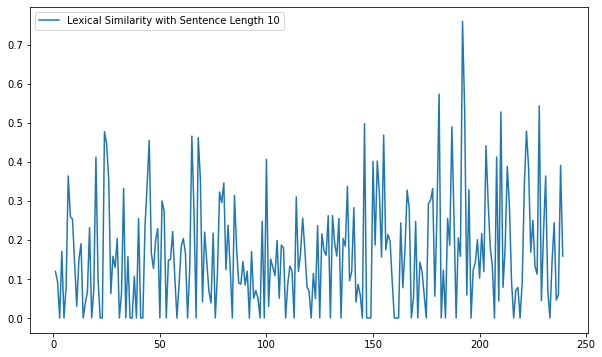

In [28]:
window_diff_score=[]
for i in range(10,110,10):
    window_diff_score.append(window_diff(ref_word,doc,i,i/10))
#plot_fig(range(10,110,10),window_diff_score,'Windowdiff Score variation with Change in Sentence Length')

ValueError: x and y must have same first dimension, but have shapes (10,) and (0,)

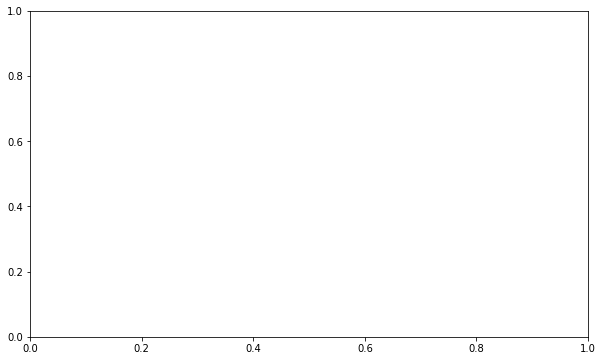

In [29]:
plot_fig(range(10,110,10),window_diff_score,'Variation of Windowdiff with relspect to Sentence Length',12)